In [1]:
import numpy as np
from astropy.io import ascii
from functions import *
from scipy.optimize import curve_fit


In [2]:
from sklearn import neighbors
from astropy.table import Table
from astropy.io import fits
import numpy as np
import pickle

In [3]:
print("loading data")
cols = ['Mstar',
        'u_r', 'g_r',
        'rabsmag',
        'SFR', 'sSFR', 'redshift',
        'flag_vsquared',
        'flag_voidfinder']

data = ascii.read('data_flags_updated_Jul31.dat', include_names=cols)

Mstar = data['Mstar']
# color
u_r = data['u_r']
g_r = data['g_r']
# absolute magnitude
rabsmag = data['rabsmag']
#star formation rate and specific SPR
SFR  = np.array(data['SFR'])
sSFR = np.array(data['sSFR'])

print("loading classification")
#classification V^2
wall_v2 = np.argwhere(data['flag_vsquared'] == 0).flatten()
void_v2 = np.argwhere(data['flag_vsquared'] == 1).flatten()
edge_v2 = np.argwhere(data['flag_vsquared'] == 2).flatten()
out_v2 = np.argwhere(data['flag_vsquared'] == 9).flatten()

#classification voidfinder
wall_vf = np.argwhere(data['flag_voidfinder'] == 0).flatten()
void_vf = np.argwhere(data['flag_voidfinder'] == 1).flatten()
edge_vf = np.argwhere(data['flag_voidfinder'] == 2).flatten()
out_vf = np.argwhere(data['flag_voidfinder'] == 9).flatten()

loading data
loading classification


In [4]:
ind_gal_depth_voidv2 = np.load('ind_gal_depth_voidv2.npy', allow_pickle=True)

In [5]:
def func_bimodal(x, a, mua, sga, askew, b, mub, sgb, bskew):
    '''returns a mixture of two skewnormal distributions'''
    return a*skewnorm.pdf(x, askew, loc=mua, scale=sga) + b*skewnorm.pdf(x, bskew, loc=mub, scale=sgb)


In [6]:
def bin_data(data,bins_,label, plot=False): 

    n1, edges1 = np.histogram(data, bins=bins_)
    dn1 = np.sqrt(n1)
    x = 0.5*(edges1[1:] + edges1[:-1])
        
    if plot == True:
        plt.errorbar(x, n1, yerr=dn1, fmt='.')        
        plt.xlabel(label, fontsize=18)
        plt.ylabel('count',fontsize=18) 
        plt.title("Binned Data ")
        plt.show()
        
    return  x,n1,dn1

In [7]:
def bimodal_fit(char_, label, bins_,voidfinder=False):
    '''
    for example: char_= g_r, char_label= 'g-r', bins_=np.linspace(-0.5,1.5, 250)
    '''
    ## property variables
    print("loading property model variables")

    # data and range 
#     if voidfinder == True:
#         char_wall = remove_nan(char_[wall_vf]) #data1_wall_vf
#         char_void = remove_nan(char_[void_vf])
#     else:
#         char_wall = remove_nan(char_[wall_v2])
#         char_void = remove_nan(char_[void_v2])

    bins_ = bins_
    label_vf = label+'_VF'
    label_v2 = label+'_V2'
    
    
    x, count_wall,dcount_wall = bin_data(char_wall,bins_,label)
    x, count_void,dcount_void = bin_data(char_void,bins_,label)
    
    popt_wall, pcov_wall = curve_fit(func_bimodal, x, count_wall)
    popt_void, pcov_void = curve_fit(func_bimodal, x, count_void)

    plt.errorbar(x, count_wall, yerr=dcount_wall, fmt='.')        
    plt.plot(x, func_bimodal(x, *popt_wall), 'r-') #label='fit: a=%5.3f, mua=%5.3f, sga=%5.3f, askew=%5.3f, b=%5.3f, mub=%5.3f, sgb=%5.3f, bskew=%5.3f' % tuple(popt))
    plt.title(label + " Wall")
    plt.xlabel(label)
    plt.ylabel("Counts")
    plt.show()
    plt.plot(x,func_bimodal(x, *popt_wall)-count_wall)
    plt.ylim(-np.max(count_wall)/5,np.max(count_wall)/5)
    plt.title('residuals')
    plt.show()
    
    
    plt.errorbar(x, count_void, yerr=dcount_void, fmt='.')  

    plt.plot(x, func_bimodal(x, *popt_void), 'r-') #label='fit: a=%5.3f, mua=%5.3f, sga=%5.3f, askew=%5.3f, b=%5.3f, mub=%5.3f, sgb=%5.3f, bskew=%5.3f' % tuple(popt))
    plt.title(label + " Void")
    plt.xlabel(label)
    plt.ylabel("Counts")
    plt.show()
    plt.plot(x,func_bimodal(x, *popt_void)-count_void)
    plt.ylim(-np.max(count_void)/5,np.max(count_void)/5)
    plt.title('residuals')
    plt.show()
    
    return popt_wall, np.sqrt(np.diag(pcov_wall)), popt_void, np.sqrt(np.diag(pcov_void))
    

In [195]:
# g_r_vf = bimodal_fit(g_r, label='g-r', bins_=np.linspace(-0.5,1.5, 250), voidfinder=True)


In [132]:
def ampl_std(fit_result):
    '''example fit_result = g_r_vf'''
    popt_wall, std_wall, popt_void, std_void = fit_result
    
    a_wall, mua_wall, sga_wall, askew_wall, b_wall, mub_wall, sgb_wall, bskew_wall = popt_wall
    a_std_wall, mua_std_wall, sga_std_wall, askew_std_wall, b_std_wall, mub_std_wall, sgb_std_wall, bskew_std_wall = std_wall

    a_void, mua_void, sga_void, askew_void, b_void, mub_void, sgb_void, bskew_void = popt_void
    a_std_void, mua_std_void, sga_std_void, askew_std_void, b_std_void, mub_std_void, sgb_std_void, bskew_std_void = std_void
#     print("(a_wall, a_std_wall, b_wall, b_std_wall, a_void, a_std_void, b_void, b_std_void) = ")
#     print(a_wall, a_std_wall, b_wall, b_std_wall, a_void, a_std_void, b_void, b_std_void)
    return a_wall, a_std_wall, b_wall, b_std_wall, a_void, a_std_void, b_void, b_std_void
  
    

In [133]:
# a_wall, a_std_wall, b_wall, b_std_wall, a_void, a_std_void, b_void, b_std_void = ampl_std(g_r_vf)

In [134]:
trend_x_void= np.linspace(1,5,5)
trend_x_void

array([1., 2., 3., 4., 5.])

In [135]:
trend_y_void=[]
trend_y_void_err=[]


In [136]:
trend_y_void.append(ampl_std(g_r_vf)[4]/ampl_std(g_r_vf)[6])
trend_y_void_err.append(np.sqrt((ampl_std(g_r_vf)[5]/ampl_std(g_r_vf)[6])**2 + (ampl_std(g_r_vf)[7]/(ampl_std(g_r_vf)[6]**2))**2))


#### galaxies by radius from center of maximal sphere (VoidFiner)

In [141]:
# cols_glx = ['ra', 'dec','redshift']
# galaxy_table = Table.read('data_flags_updated_Jul31.dat', format =  'ascii',include_names=cols_glx )

# h=1
# DtoR = np.pi/180.
# RtoD = 180./np.pi
# c = 3e5

# r_gal = c*galaxy_table['redshift'].data/(100*h)
# ra = galaxy_table['ra'].data
# dec = galaxy_table['dec'].data

# ra_radian = ra*DtoR

# dec_radian = dec*DtoR

# x_gal = r_gal*np.cos(ra_radian)*np.cos(dec_radian)

# y_gal = r_gal*np.sin(ra_radian)*np.cos(dec_radian)

# z_gal = r_gal*np.sin(dec_radian)

# num_gal = x_gal.shape[0]
    
# gals_xyz = np.concatenate((x_gal.reshape(num_gal,1),
#                                  y_gal.reshape(num_gal,1),
#                                  z_gal.reshape(num_gal,1)), axis=1)



In [147]:
# cols_maximal = ['x', 'y','z', 'radius']
# maximal_table = Table.read('ALL_comoving_maximal.txt', format =  'ascii',include_names=cols_maximal )
# maximal_radius = maximal_table['radius']
# maximal_x = maximal_table['x']
# maximal_y = maximal_table['y']
# maximal_z = maximal_table['z']

In [149]:
# # x_voidv2 = np.array(t['x'])
# # y_voidv2  = np.array(t['y'])
# # z_voidv2  = np.array(t['z'])
# # radius_voidv2  = np.array(t['radius'])

# num_voidvf  = maximal_x.shape[0]
# voidvf_xyz = np.concatenate((maximal_x.reshape(num_voidvf ,1),
#                                  maximal_y.reshape(num_voidvf ,1),
#                                  maximal_z.reshape(num_voidvf ,1)), axis=1)

In [154]:
# for i in np.linspace(0.1,2,50):
#     tree = neighbors.KDTree(gals_xyz, metric = 'euclidean')
#     ind =  tree.query_radius(voidvf_xyz, r =i*maximal_radius)
#     with open('galaxy_in_voidvf_indices'+str(i), 'wb') as ind_file:
#         pickle.dump(ind, ind_file)

In [155]:
# list_ = []
# for i in np.linspace(0.1,2,50):
#     with open('galaxy_in_voidvf_indices'+str(i), 'rb') as ind_file:
#         list_.append(pickle.load(ind_file))
# list_= np.array(list_)
# len(list_)

# #flatten the index file, np.flatten doesnt get it done
# ind_maximal_voidgal=[] # 18 arrays, each contains the list of galaxies within that radius of the maximal sphere
# temp=[]
# for k in range(len(list_)):
#     for i in range(len(list_[k])): #641
#         for j in range(len(list_[k][i])): # number of particles in maximal sphere
#             temp.append(list_[k][i][j]) 
#     ind_maximal_voidgal.append(temp)
#     temp=[]
# ind_maximal_voidgal=np.array(ind_maximal_voidgal)

# np.array(ind_maximal_voidgal).shape

(50,)

In [ ]:

# void_vf = ind_maximal_voidgal[i]


In [8]:
def bimodal_fit_void(char_void, label, bins_,voidfinder=False):
    '''
    for example: char_= g_r, char_label= 'g-r', bins_=np.linspace(-0.5,1.5, 250)
    '''
    ## property variables
    print("loading property model variables")

    # data and range 
#     if voidfinder == True:
#         char_wall = remove_nan(char_[wall_vf]) #data1_wall_vf
#         char_void = remove_nan(char_[void_vf])
#     else:
#         char_wall = remove_nan(char_[wall_v2])
#         char_void = remove_nan(char_[void_v2])

    bins_ = bins_
    label_vf = label+'_VF'
    label_v2 = label+'_V2'
    
    
#     x, count_wall,dcount_wall = bin_data(char_wall,bins_,label)
    x, count_void,dcount_void = bin_data(char_void,bins_,label)
    
#     popt_wall, pcov_wall = curve_fit(func_bimodal, x, count_wall)
    popt_void, pcov_void = curve_fit(func_bimodal, x, count_void)

#     plt.errorbar(x, count_wall, yerr=dcount_wall, fmt='.')        
#     plt.plot(x, func_bimodal(x, *popt_wall), 'r-') #label='fit: a=%5.3f, mua=%5.3f, sga=%5.3f, askew=%5.3f, b=%5.3f, mub=%5.3f, sgb=%5.3f, bskew=%5.3f' % tuple(popt))
#     plt.title(label + " Wall")
#     plt.xlabel(label)
#     plt.ylabel("Counts")
#     plt.show()
#     plt.plot(x,func_bimodal(x, *popt_wall)-count_wall)
#     plt.ylim(-np.max(count_wall)/5,np.max(count_wall)/5)
#     plt.title('residuals')
#     plt.show()
    
    
    plt.errorbar(x, count_void, yerr=dcount_void, fmt='.')  

    plt.plot(x, func_bimodal(x, *popt_void), 'r-') #label='fit: a=%5.3f, mua=%5.3f, sga=%5.3f, askew=%5.3f, b=%5.3f, mub=%5.3f, sgb=%5.3f, bskew=%5.3f' % tuple(popt))
    plt.title(label + " Void")
    plt.xlabel(label)
    plt.ylabel("Counts")
    plt.show()
    plt.plot(x,func_bimodal(x, *popt_void)-count_void)
    plt.ylim(-np.max(count_void)/5,np.max(count_void)/5)
    plt.title('residuals')
    plt.show()
    
    return popt_void, np.sqrt(np.diag(pcov_void))
    

loading property model variables


/home/fzaidoun/anaconda3/envs/him/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


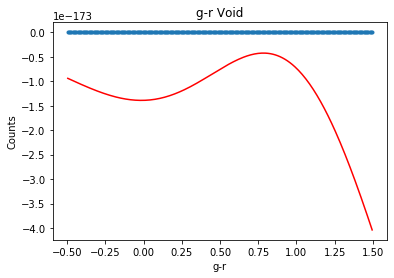

/home/fzaidoun/anaconda3/envs/him/lib/python3.6/site-packages/ipykernel/__main__.py:47: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


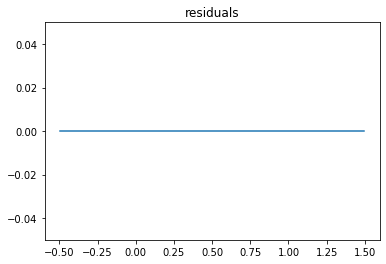

loading property model variables


/home/fzaidoun/anaconda3/envs/him/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


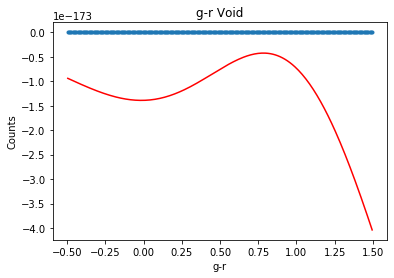

/home/fzaidoun/anaconda3/envs/him/lib/python3.6/site-packages/ipykernel/__main__.py:47: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.


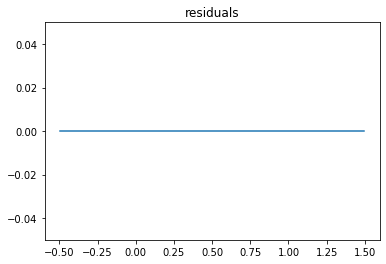

loading property model variables


/home/fzaidoun/anaconda3/envs/him/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


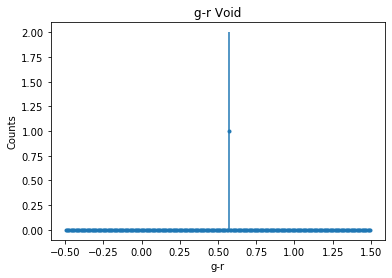

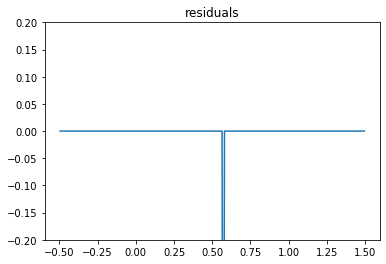

loading property model variables


/home/fzaidoun/anaconda3/envs/him/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


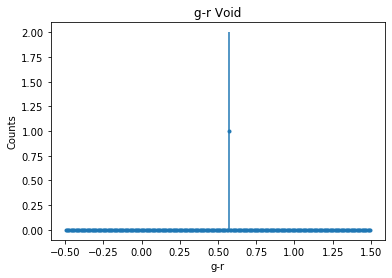

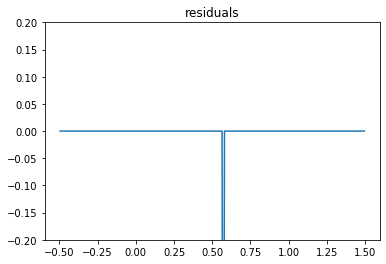

loading property model variables


/home/fzaidoun/anaconda3/envs/him/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


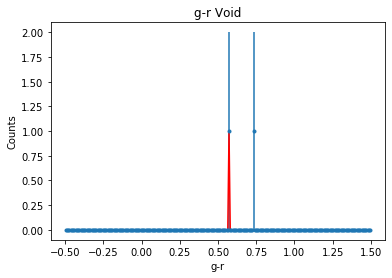

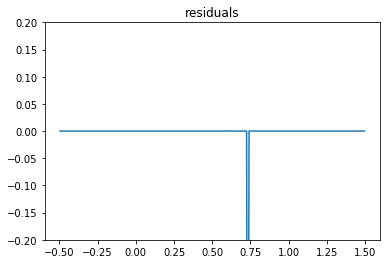

loading property model variables


/home/fzaidoun/anaconda3/envs/him/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


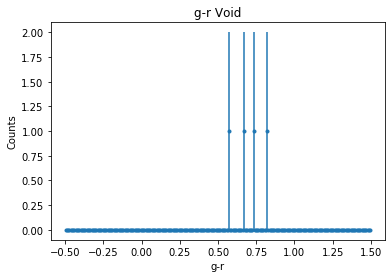

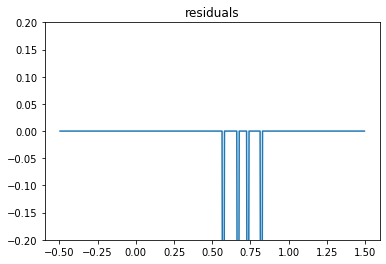

loading property model variables


In [ ]:
for i in range(len(ind_gal_depth_voidv2)):
    bimodal_fit_void(g_r[np.asarray(list(ind_gal_depth_voidv2[i]), dtype=int).flatten()], 'g-r', bins_=np.linspace(-0.5,1.5, 250))

In [54]:
for i in range(35,len(ind_gal_depth_voidv2),1):
    bimodal_fit_void(sSFR[np.asarray(list(ind_gal_depth_voidv2[i]), dtype=int).flatten()], 'sSFR', bins_=np.linspace(-13,-8, 250))

loading property model variables


RuntimeError: Optimal parameters not found: gtol=0.000000 is too small, func(x) is orthogonal to the columns of
  the Jacobian to machine precision.

In [175]:
def ampl_std_void(fit_result):
    '''example fit_result = g_r_vf'''
    popt_void, std_void = fit_result
    
#     a_wall, mua_wall, sga_wall, askew_wall, b_wall, mub_wall, sgb_wall, bskew_wall = popt_wall
#     a_std_wall, mua_std_wall, sga_std_wall, askew_std_wall, b_std_wall, mub_std_wall, sgb_std_wall, bskew_std_wall = std_wall

    a_void, mua_void, sga_void, askew_void, b_void, mub_void, sgb_void, bskew_void = popt_void
    a_std_void, mua_std_void, sga_std_void, askew_std_void, b_std_void, mub_std_void, sgb_std_void, bskew_std_void = std_void
#     print("(a_wall, a_std_wall, b_wall, b_std_wall, a_void, a_std_void, b_void, b_std_void) = ")
#     print(a_wall, a_std_wall, b_wall, b_std_wall, a_void, a_std_void, b_void, b_std_void)
    return a_void, a_std_void, b_void, b_std_void
  

loading property model variables


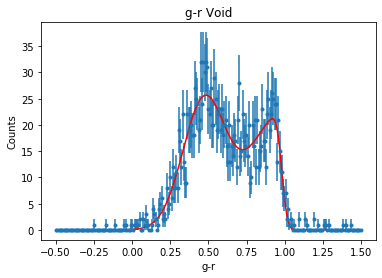

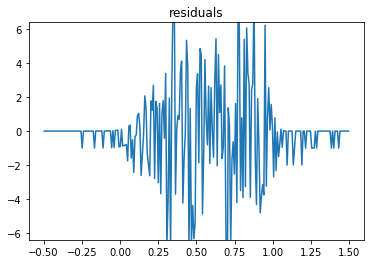

loading property model variables


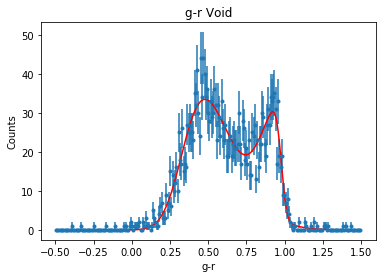

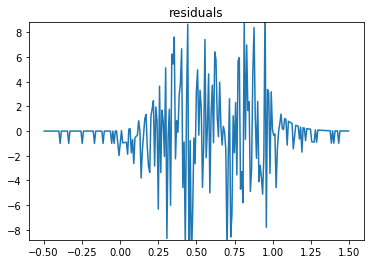

loading property model variables


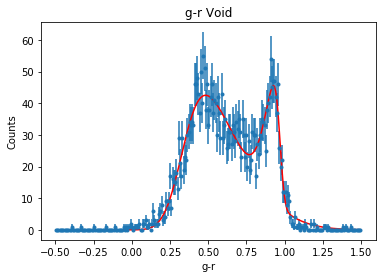

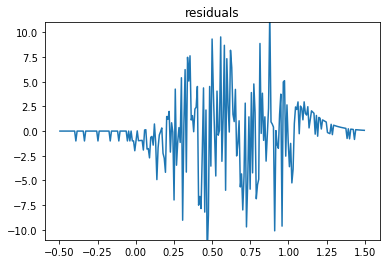

loading property model variables


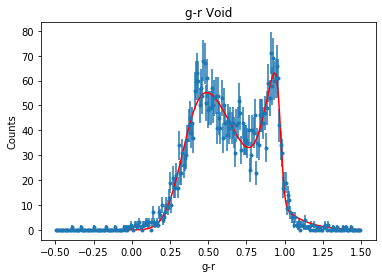

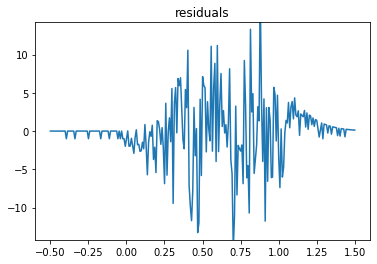

loading property model variables


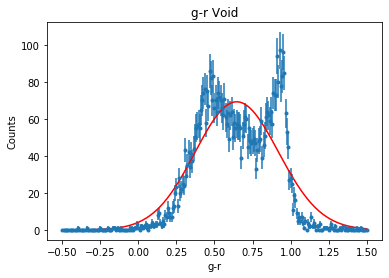

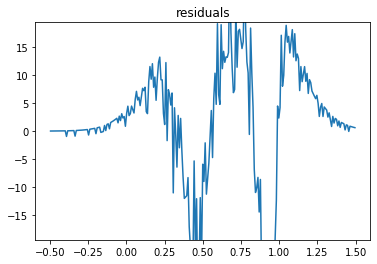

loading property model variables


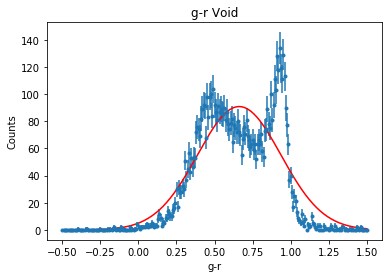

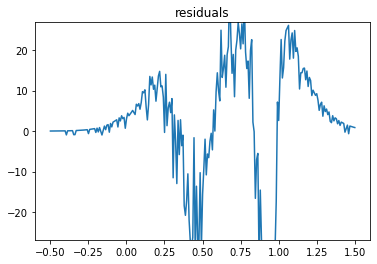

loading property model variables


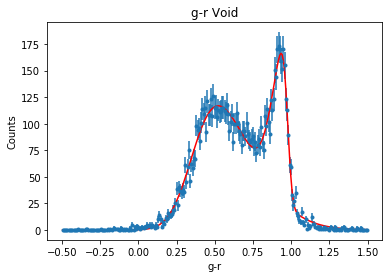

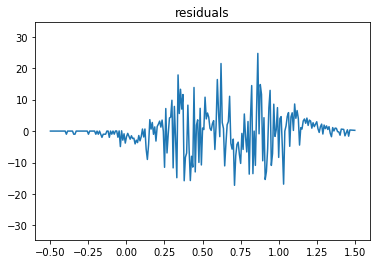

loading property model variables


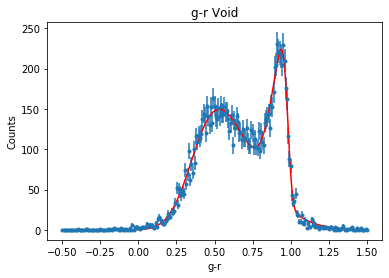

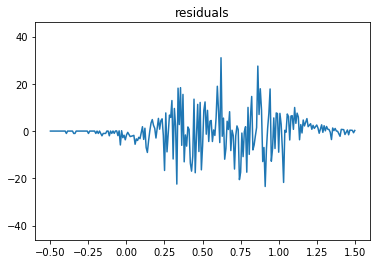

loading property model variables


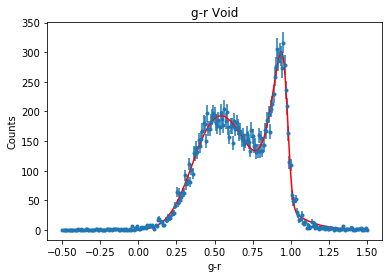

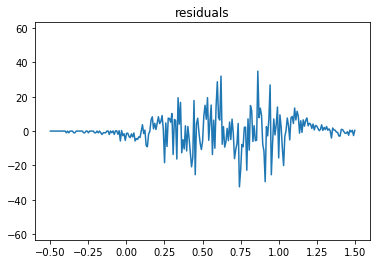

loading property model variables


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 1800.

In [176]:
trend_y_void=[]
trend_y_void_err=[]
for i in range(15,50,1):
    g_r_vf = bimodal_fit_void(g_r[ind_maximal_voidgal[i]], label='g-r', bins_=np.linspace(-0.5,1.5, 250), voidfinder=True)
    ampl_std_void(g_r_vf)
    trend_y_void.append(ampl_std_void(g_r_vf)[0]/ampl_std_void(g_r_vf)[2])
    trend_y_void_err.append(np.sqrt((ampl_std_void(g_r_vf)[1]/ampl_std_void(g_r_vf)[2])**2 + (ampl_std_void(g_r_vf)[3]/(ampl_std_void(g_r_vf)[2]**2))**2))


In [191]:
# yerr_test=np.sqrt(trend_y_void_test)

In [192]:
# trend_y_void_test=np.sort(trend_y_void)

Text(0, 0.5, 'ampl1/ampl2')

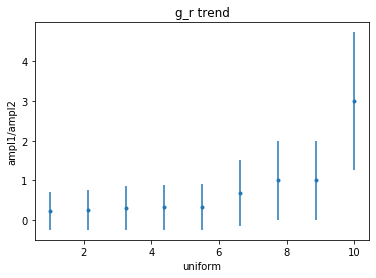

In [194]:
# # plt.scatter(np.linspace(1,10,9), trend_y_void_test, )   
# plt.errorbar(np.linspace(1,10,9), trend_y_void_test, yerr=yerr_test, fmt='.')        
# plt.title("g_r trend")
# plt.xlabel("uniform")
# plt.ylabel("ampl1/ampl2")